<a href="https://colab.research.google.com/github/HBaldwin3/CaseStudy_FSH_LaoPDR/blob/main/Backscatter_04_21_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up workspace

## Mount Google Drive

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


## Install and import packages

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from osgeo import gdal  
from sklearn.metrics import r2_score
import seaborn as sns; sns.set(color_codes=True)
import imageio
from scipy.interpolate import *
from scipy.stats import *
from scipy import ndimage, misc
import matplotlib.lines as lines
import glob
import math
import sklearn
import scipy
from scipy import stats

In [ ]:
print(scipy.__version__)

1.4.1


## Navigate to Backscatter Directory

5 files required for this exercise:


1.   LiDAR training set
2.   LiDAR testing set
3.   Backscatter power training set
4.   Backscatter power testing set
5.   Backscatter power full data set



[insert flowchart and description of preprocessing]

In [ ]:
cd /content/notebooks/Backscatter_10-19-2020/

/content/mnt/My Drive/Colab Notebooks/Backscatter_10-19-2020


In [ ]:
%ls

Backscatter-pw_testing.tif
Backscatter-pw_training.tif
check_backscatter_estimate.tif.tif
EstimatedHeight_resamp_6ha_curvefit_v10.tif
EstimatedHeight_resamp_6ha_curvefit_v11.tif
EstimatedHeight_resamp_6ha_curvefit_v12.tif
EstimatedHeight_resamp_6ha_curvefit_v13.tif
EstimatedHeight_resamp_6ha_curvefit_v14.tif
EstimatedHeight_resamp_6ha_curvefit_v15.tif
EstimatedHeight_resamp_6ha_curvefit_v16.tif
EstimatedHeight_resamp_6ha_curvefit_v17.tif
EstimatedHeight_resamp_6ha_curvefit_v18.tif
EstimatedHeight_resamp_6ha_curvefit_v1.tif
EstimatedHeight_resamp_6ha_curvefit_v20.tif
EstimatedHeight_resamp_6ha_curvefit_v2.tif
EstimatedHeight_resamp_6ha_curvefit_v3.tif
EstimatedHeight_resamp_6ha_curvefit_v4.tif
EstimatedHeight_resamp_6ha_curvefit_v5.tif
EstimatedHeight_resamp_6ha_curvefit_v6.tif
EstimatedHeight_resamp_6ha_curvefit_v7.tif
EstimatedHeight_resamp_6ha_linear.tif
EstimatedHeight_resamp_6ha_log.tif
EstimatedHeight_resamp_6ha_v3.tif
EstimatedHeight_resamp8v2.tif
EstimatedHeight_testcheck.tif
Es

#Preprocessing

###  Read in LiDAR Training Data

The x data is the LiDAR training data (70% of total lidar data, randomly selected using the FNF mask in ArcMap 10.7). When fitting, this is h in Yang Lei's equation.

In [ ]:
lidar = "LiDAR_training.tif"

In [ ]:
x = gdal.Open(lidar)
xdata = x.ReadAsArray()

## Read in Backscatter Power Training Data

The y data is the backscatter power training data (pixels of backscatter power corresponding to the LiDAR training data set). When fitting this is "" in Yang Lei's equation. 

In [ ]:
backscatter = "Backscatter-pw_training.tif"

In [ ]:
y = gdal.Open(backscatter)
ydata = y.ReadAsArray()

## Clean Input Training Data

Check to make sure they are the same size!!

In [ ]:
print(ydata.shape)
print(xdata.shape)

(86, 139)
(86, 139)


Array version: deal with NoData Values

In [ ]:
x_nan2 = np.where(xdata>200, np.NaN, xdata)
y_nan2 = np.where(ydata>200, np.NaN, ydata)

x_nan = np.where(x_nan2<0, np.NaN, x_nan2)
y_nan = np.where(y_nan2<0, np.NaN, y_nan2)
print(x_nan)
print(y_nan)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan  7.6439667 ...        nan        nan        nan]
 [       nan        nan 10.663815  ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan 0.09795077 ...        nan        nan        nan]
 [       nan        nan 0.01104809 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


### Deal with NoData values

Squash 2D array into 1D

x is lidar and y is backscatter power

In [ ]:
y_ravel = np.array(y_nan).ravel()
print("y_ravel", y_ravel.shape) 

x_ravel = np.array(x_nan).ravel()
print("x_ravel", x_ravel.shape) 

y_ravel (11954,)
x_ravel (11954,)


Ignore nan values in both inputs by creating a mask called "bad". Then compress the ravelled x and y data with the 'bad' mask
to create two new datasets xnew and ynew that should match in size and shape (1D).


In [ ]:
bad = ~np.logical_or(np.isnan(x_ravel), np.isnan(y_ravel))

xnew = np.compress(bad, x_ravel)
ynew = np.compress(bad, y_ravel)

This "bad mask" which allows us to graph, won't work with 2D.

In [ ]:
print(xnew)
print(ynew)
print(xnew.shape, ynew.shape)

[ 7.6439667 10.663815   4.649369  ... 11.494115  10.227021  10.3594265]
[0.09795077 0.01104809 0.07137264 ... 0.0617207  0.05477591 0.04706474]
(4681,) (4681,)


## Sanity Check 

Visualize training data - needs to be 1D (and nans removed) to work

best fit line:
y = 0.018162 + 0.003302x


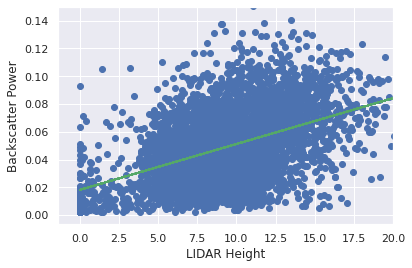

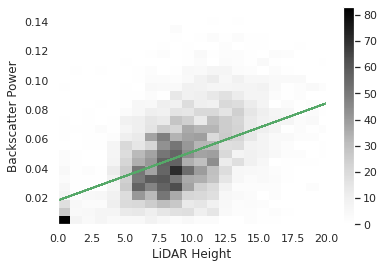

In [ ]:
#line of best fit
#https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denom = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denom
    a = ybar - b * xbar

    print('best fit line:\ny = {:.6f} + {:.6f}x'.format(a, b))

    return a, b

a, b = best_fit(xnew, ynew)
yfit = [a + b * xi for xi in xnew]

#Scatter plot
fig = plt.figure()
plt.scatter(xnew, ynew) #, c=colors, alpha=0.5
plt.plot(xnew, yfit, 'g')
plt.ylim(top=0.15)
plt.xlim(right=20)
plt.xlabel('LIDAR Height')
plt.ylabel('Backscatter Power')
plt.show()

#Density plot: https://python-graph-gallery.com/83-basic-2d-histograms-with-matplotlib/
plt.plot(xnew, yfit, 'g')
plt.hist2d(xnew, ynew, bins=(30, 30), cmap=plt.cm.Greys)
plt.ylim(top=0.15)
plt.xlim(right=20)
plt.colorbar()

plt.xlabel('LiDAR Height')
plt.ylabel('Backscatter Power')
plt.show()

# Train Model

## Define Yang Lei's equation for fitting

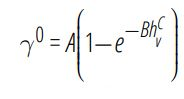

h is the vegetation height (ie lidar when fitting)
a, b, and c are fitting coefficients (no physical meaning)

In [ ]:
def func(h, a, b, c):
    return a * (1 - np.exp(-b * (np.power(h, c))))

Try scipy's least_squares package https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares

In [ ]:
from scipy.optimize import least_squares
args = xnew, ynew
N = np.array([0, 0, 0])
out = least_squares(func, args, N, '3-point')
print(out)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_lsq/least_squares.py:751: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if jac not in ['2-point', '3-point', 'cs'] and not callable(jac):


ValueError: ignored

https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly#

In [ ]:
#link: https://stackoverflow.com/questions/19791581/how-to-use-leastsq-function-from-scipy-optimize-in-python-to-fit-both-a-straight

import random

from scipy.optimize import least_squares

a = np.array(xnew, dtype=np.float)

b = np.array(ynew, dtype=np.float)
print("Expect", [a, b])

def f(args):
    x, y = args
    return a * (1 - np.exp(-b * (np.power(x, c))))

x0 = [0, 0]

result = least_squares(fun=f, x0=x0)

print(result.x)


Expect [array([ 7.64396667, 10.66381454,  4.64936876, ..., 11.49411488,
       10.22702122, 10.3594265 ]), array([0.09795077, 0.01104809, 0.07137264, ..., 0.0617207 , 0.05477591,
       0.04706474])]
[0. 0.]


Another curve_fit example

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in power


61.714304864073135 0.0002148255739304549 0.5946434184122676


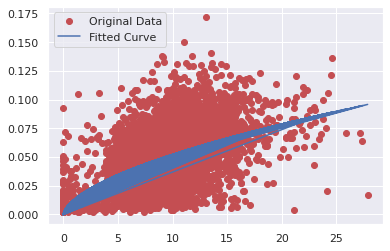

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import sympy as sym

"""
Generate some data, let's imagine that you already have this. 
"""
x = xnew
y = ynew

"""
Plot your data
"""
plt.plot(x, y, 'ro',label="Original Data")

"""
brutal force to avoid errors
"""    
x = np.array(x, dtype=float) #transform your data in a numpy array of floats 
y = np.array(y, dtype=float) #so the curve_fit can work

"""
create a function to fit with your data. a, b, c and d are the coefficients
that curve_fit will calculate for you. 
In this part you need to guess and/or use mathematical knowledge to find
a function that resembles your data
"""
#def func(x, a, b, c, d):
#    return a*x**3 + b*x**2 +c*x + d

def func(h, a, b, c):
    return a * (1 - np.exp(-b * (np.power(h, c))))

"""
make the curve_fit
"""
#RuntimeError with default maxfev, "Optimal parameters not found: Number of calls to function has reached maxfev = 800"
popt, pcov = curve_fit(func, x, y, maxfev=100000)

"""
The result is:
popt[0] = a , popt[1] = b, popt[2] = c and popt[3] = d of the function,
so f(x) = popt[0]*x**3 + popt[1]*x**2 + popt[2]*x + popt[3].
"""
print (popt[0], popt[1], popt[2])

"""
Use sympy to generate the latex sintax of the function
"""
#xs = sym.Symbol('\lambda')    
#tex = sym.latex(func(xs,*popt)).replace('$', '')
#plt.title(r'$f(\lambda)= %s$' %(tex),fontsize=16)

"""
Print the coefficients and plot the funcion.
"""

plt.plot(x, func(x, *popt), label="Fitted Curve") #same as line above \/
#plt.plot(x, popt[0]*x**3 + popt[1]*x**2 + popt[2]*x + popt[3], label="Fitted Curve") 

plt.legend(loc='upper left')
plt.show()
#the result is: a = 0.849195983017 , b = -1.18101681765

Try numpy's polyfit https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

## (Optional) Determine coefficients using scipy curve-fit package

curve_data assumes ydata = f(xdata, *params) + eps.
In the case of fitting, the xdata is h, or the LiDAR measured vegetation height. The curve_fit package will find the values for A, B, and C that will best fit the input data. 
N is the list of initial values for these coeffients, which can be changed (but hasn't shown to impact the results much -- altho actually looks like it might now that we have a lot smaller input dataset). 

curvefit parameters:

*   func = function name
*   xnew = LiDAR, or measured, 'ground truth' height
*   ynew = ALOS PALSAR backscatter power (preprocessed, clipped and aligned with LiDAR)
*   popt = optimized values (for a, b, and c)
*   pcov = covariance values

In [ ]:
N = [8, 8, 8]

In [ ]:
popt, pcov = curve_fit(func, xnew, ynew, p0=N, maxfev=50000000) #maxfev=50000000
print("Optimized values: ", popt)
print("covariance values: ", pcov)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


Optimized values:  [8.60596417e+01 1.65841247e-04 5.70391779e-01]
covariance values:  [[ 2.35046302e+09 -4.55602259e+03 -4.89815059e+03]
 [-4.55602259e+03  8.83117148e-03  9.49420019e-03]
 [-4.89815059e+03  9.49420019e-03  1.05543821e-02]]


# Test Model

## Read in Testing LiDAR & Backscatter

In [ ]:
%ls

Backscatter-pw_testing.tif
Backscatter-pw_training.tif
check_backscatter_estimate.tif.tif
EstimatedHeight_resamp_6ha_curvefit_v10.tif
EstimatedHeight_resamp_6ha_curvefit_v11.tif
EstimatedHeight_resamp_6ha_curvefit_v12.tif
EstimatedHeight_resamp_6ha_curvefit_v13.tif
EstimatedHeight_resamp_6ha_curvefit_v14.tif
EstimatedHeight_resamp_6ha_curvefit_v15.tif
EstimatedHeight_resamp_6ha_curvefit_v16.tif
EstimatedHeight_resamp_6ha_curvefit_v17.tif
EstimatedHeight_resamp_6ha_curvefit_v18.tif
EstimatedHeight_resamp_6ha_curvefit_v1.tif
EstimatedHeight_resamp_6ha_curvefit_v20.tif
EstimatedHeight_resamp_6ha_curvefit_v2.tif
EstimatedHeight_resamp_6ha_curvefit_v3.tif
EstimatedHeight_resamp_6ha_curvefit_v4.tif
EstimatedHeight_resamp_6ha_curvefit_v5.tif
EstimatedHeight_resamp_6ha_curvefit_v6.tif
EstimatedHeight_resamp_6ha_curvefit_v7.tif
EstimatedHeight_resamp_6ha_linear.tif
EstimatedHeight_resamp_6ha_log.tif
EstimatedHeight_resamp_6ha_v3.tif
EstimatedHeight_resamp8v2.tif
EstimatedHeight_testcheck.tif
Es

In [ ]:
lidar2 = "LiDAR_testing.tif"

In [ ]:
x2 = gdal.Open(lidar2)
xtest=x2.ReadAsArray()

In [ ]:
backscatter2 = "Backscatter-pw_testing.tif"

In [ ]:
y2 = gdal.Open(backscatter2)
ytest=y2.ReadAsArray()

In [ ]:
print(ytest.shape)
print(xtest.shape)

(86, 139)
(86, 139)


##Array version: initialize empty array

In [ ]:
y_empty = np.empty(ytest.shape, dtype=float)
print (y_empty)

[[ 0.00000000e+000  4.66863274e-310  4.88156621e-319 ...  1.39067116e-309
   1.06149314e-248  5.36446301e+173]
 [ 3.39394327e-111  8.82880659e+199  1.01282937e-109 ...  7.35274595e+223
   2.35039946e+180  1.23755836e+214]
 [ 6.01334668e-154  4.53656690e+223  1.45817696e-094 ...  9.64347994e-313
   4.57400437e-308 -3.38460698e+125]
 ...
 [ 2.26726761e+161  1.28625507e+248  1.33360291e+241 ...  8.23249613e-019
   6.12295390e-086  3.59617240e+252]
 [ 1.47311724e+171  4.94065646e-324  8.48798317e-314 ...  8.72923021e+252
   1.48890325e+195  1.33360297e+241]
 [ 4.68906078e+170  8.82131798e+199  2.14819279e-308 ...  2.71963835e-307
   1.33360314e+241  2.90331464e-310]]


## Define Yang Lei's equation for estimation

*   G = gamma naught, or the preprocessed ALOS PALSAR mosaic, in backscatter power --whole mosaic (in equation 1, this is the return)
*   a, b, and c are fitting parameters determined above during curve_fit
*   h is the height, earlier we used the lidar height to determine the best fitting parameters but now h will be our output (so equation rearranged to reflect this) ie. an estimated height based on the mosaic values and determined coefficients

In [ ]:
def func2(G, a, b, c):
    return np.power(((np.log((-G/a)+1))/(-b)),(1/c))

### My math...

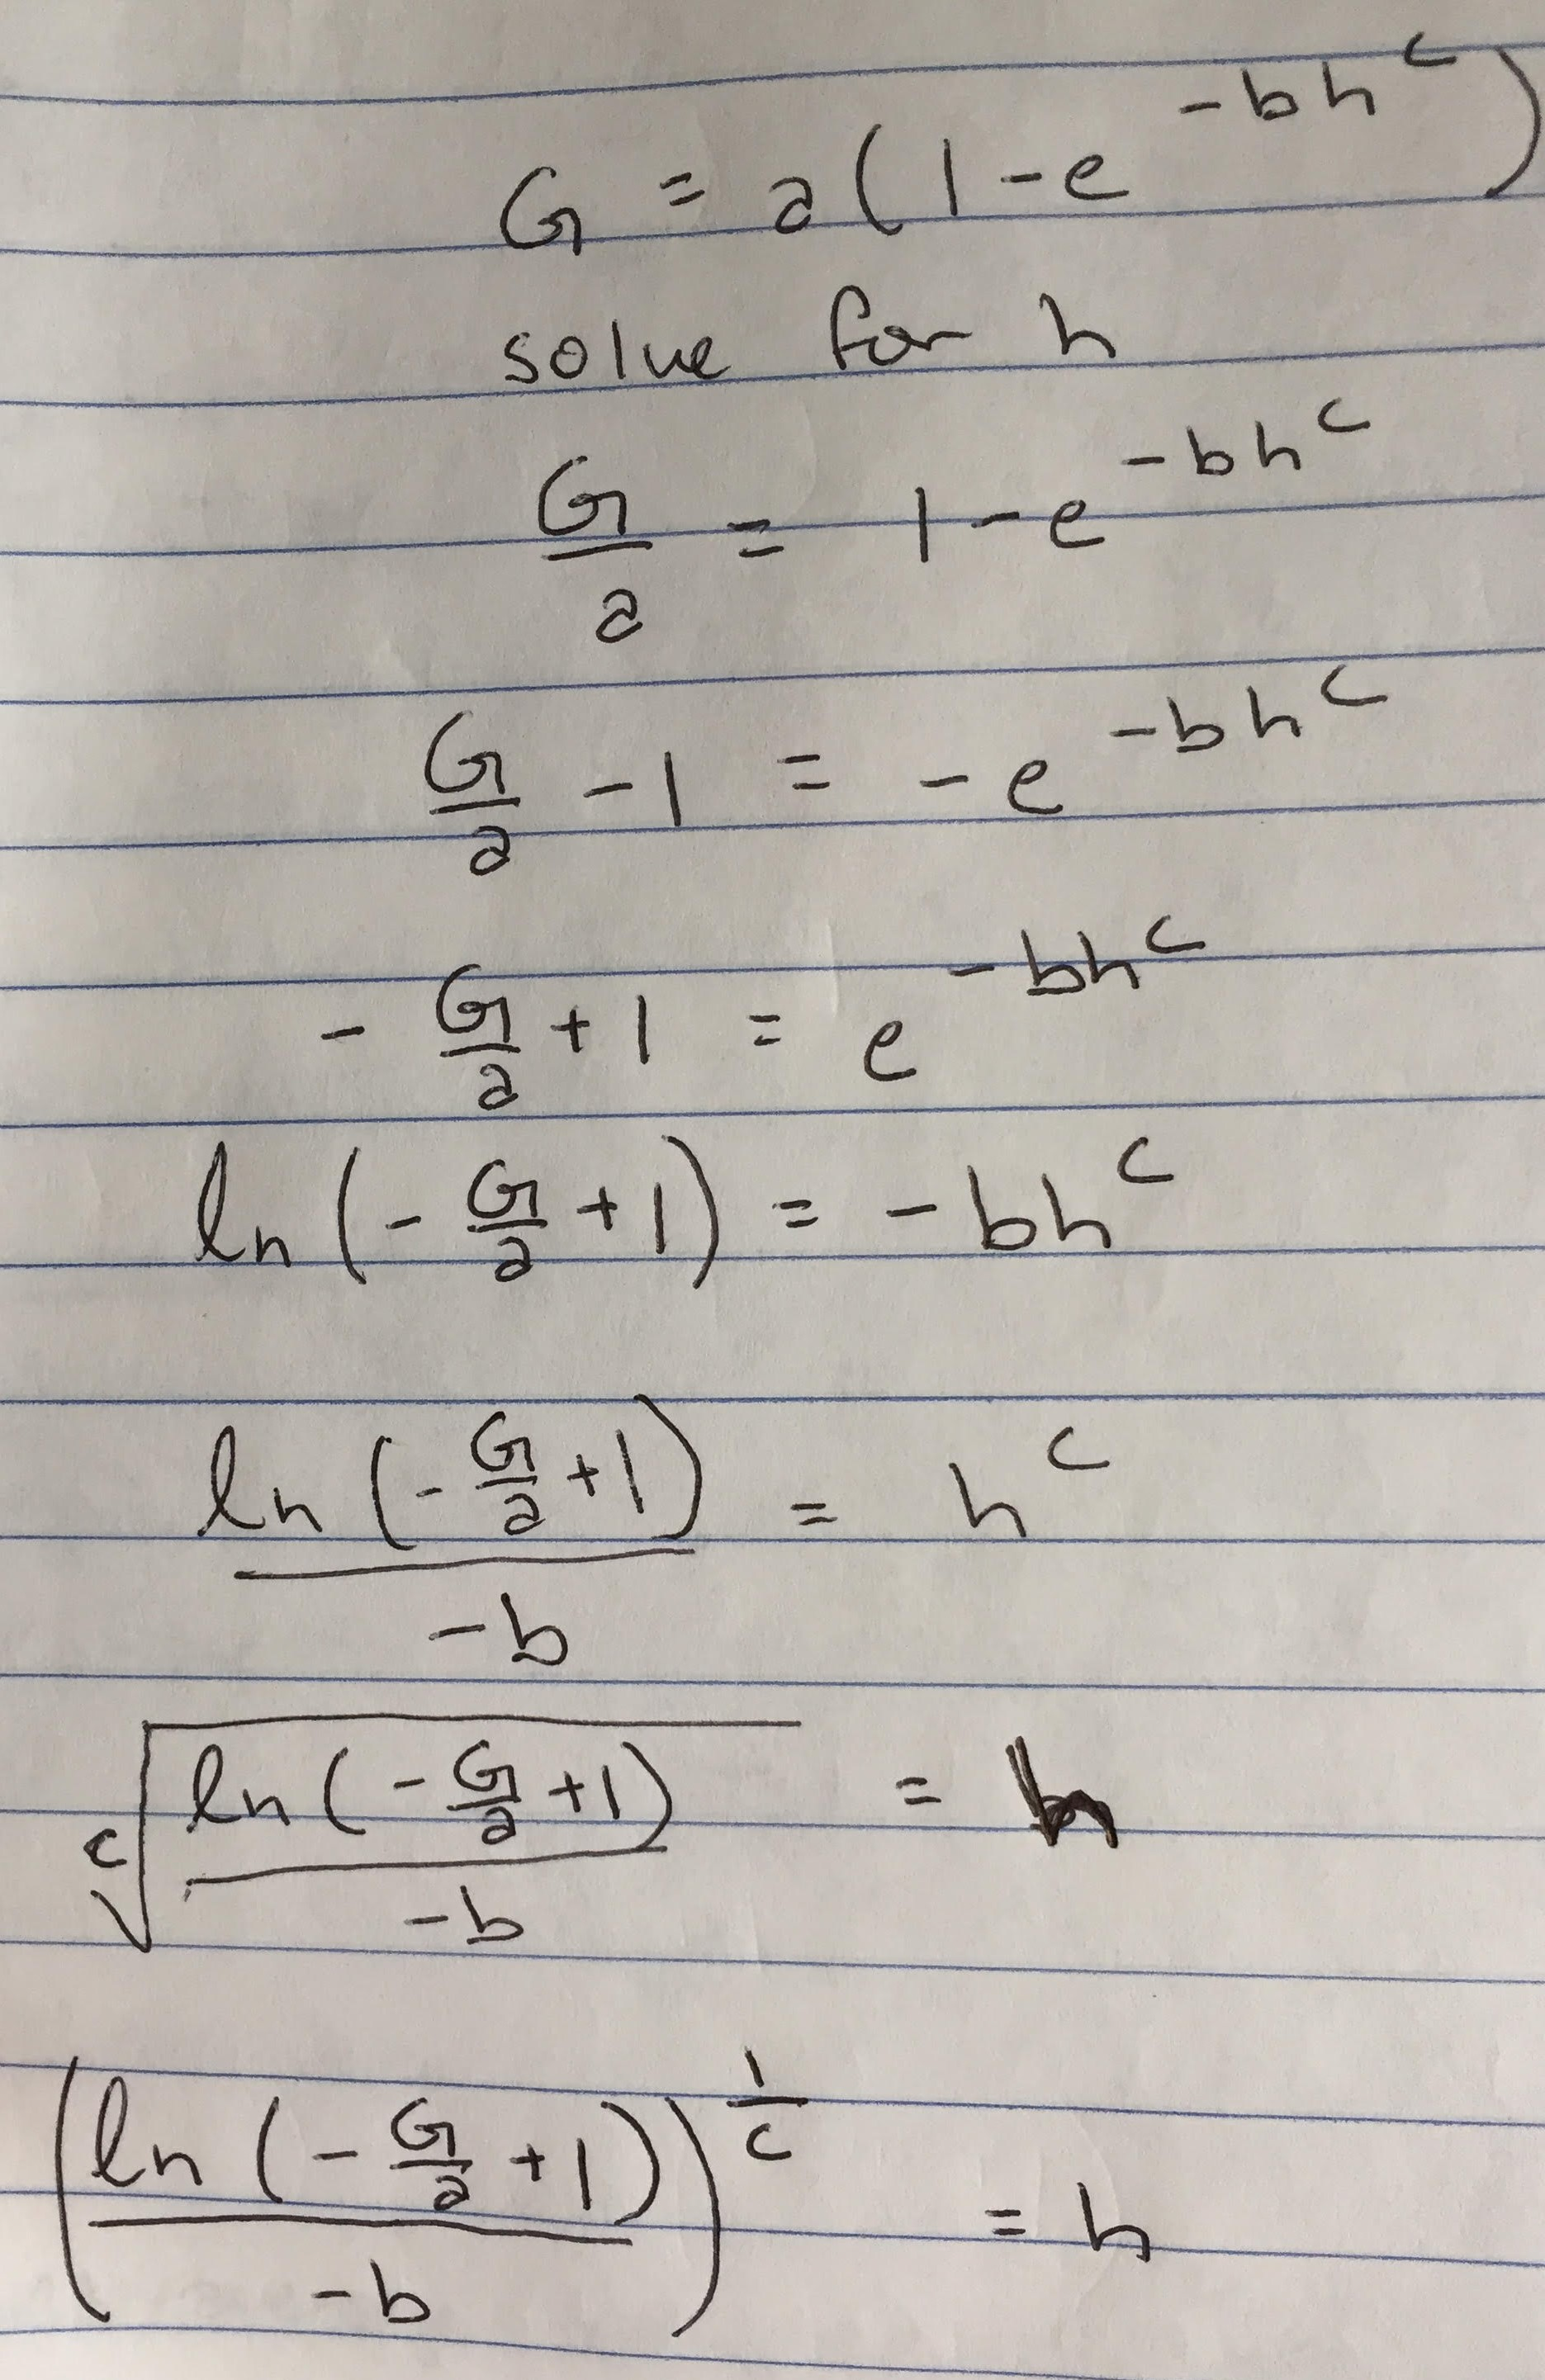

This empty array should be the same size (and shape, but for testing can leave 1D) as the test data. This is where the estimated height will be input based on the equation.

In [ ]:
length = len(ytestnew)
y_test_empty = np.empty(length)

NameError: ignored

In [ ]:
print(ytestnew.shape)
print(y_test_empty.shape)

In [ ]:
print(y_empty)

In [ ]:
rows = ytest.shape[0]
print (rows)

86


In [ ]:
cols = xtest.shape[1]
print (cols)

139


In [ ]:
for i in range (0, rows):
  for j in range (0, cols):
    y_empty[i, j] = func2(ytest[i, j], a, b, c)

NameError: ignored

## Define coefficients for Yang Lei's equation

These A, B and C coefficients are those determined by the curve_fit package

In [ ]:
a = popt[0]
b = popt[1]
c = popt[2]
print(a, b, c)

47.227498298989794 0.0002807074014902727 0.5947212860341494


You can manually test other values. These are the optimal values determined in the previous Colab (without train/test sampling or removing non forest areas).

In [ ]:
a = 0.63152915
b = 0.01037093
c = 0.9223795

These values are the ones determined to be most appropriate for Yang Lei's study in Maine.

In [ ]:
a = 0.11
b = 0.0622
c = 1.0143

These are the values derived from Yifan Yu's equation (and then simplifying).

In [ ]:
a = 0.021563
b = 0.03119109504
c = 2.0062

Manual Adjustment

In [ ]:
a = 0.3
b = 0.04
c = 0.7

v21 (from curve_fit)

In [ ]:
a = 61.714304864073135 
b = 0.0002148255739304549 
c = 0.5946434184122676

## Estimate FSH on test dataset

The estimated height will be stored in y_test_empty. The height is estimated using the testing dataset from the annual ALOS PALSAR mosaic and the coefficients selected in the previous step. 

##Define equations based on Sassan Saatchi's SAR Handbook Chapter for estimating FSH from backscatter

This method can be used in place of the coefficients/Yang Lei method

Define Linear Equation

In [ ]:
def func_lin(g):
  return 0.0033*g + 0.0182

Define logarithmic Equation

In [ ]:
def func_log(g):
  return 0.0157*np.log(g) + 0.016

# Create estimated forest stand height map

## Version of the equation for applying to full annual ALOS PALSAR mosaic

func2 that was defined earlier

*   G = gamma naught, or the preprocessed ALOS PALSAR mosaic, in backscatter power --whole mosaic (in equation 1, this is the return)
*   a, b, and c are fitting parameters determined above during curve_fit
*   h is the height, earlier we used the lidar height to determine the best fitting parameters but now h will be our output (so equation rearranged to reflect this) ie. an estimated height based on the mosaic values and parameters



## Read in preprocessed ALOS PALSAR mosaic

In [ ]:
%ls

In [ ]:
gf = gdal.Open("gamma_resamp_6ha.tif")
gf_data = gf.ReadAsArray()

 Sanity check: Run the following codeblock to check that the resampled dataset (gdata) is smaller than the original annual ALOS PALSAR mosaic dataset (gf_data) by the appropriate resample factor decided above.

 Make sure that the gf_data values are low numbers as expected for backscatter power (don't want any sneaky -128 as NoData values to have gotten averaged in there!)

In [ ]:
print(gf_data.shape)
print(gf_data)

(451, 451)
[[-3.4028235e+38  2.9282568e-02  4.4150196e-02 ...  2.7993999e-02
   4.2859830e-02  4.8376560e-02]
 [-3.4028235e+38  6.2972084e-02  5.1128987e-02 ...  5.6837127e-02
   4.9123976e-02  4.6532705e-02]
 [-3.4028235e+38  5.6647211e-02  6.2401716e-02 ...  8.2495116e-02
   4.1719999e-02  2.4582297e-02]
 ...
 [-3.4028235e+38  1.1909009e-02  1.3253165e-02 ...  7.1011394e-02
   6.1880950e-02  2.0255886e-02]
 [-3.4028235e+38  2.4596609e-02  1.7164355e-02 ...  1.0629750e-01
   7.5519450e-02  5.0530475e-02]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]]


##Initialize empty array of shape of ALOS PALSAR mosaic input

In [ ]:
g_empty = np.empty(gf_data.shape, dtype=float)
print (g_empty)

NameError: ignored

In [ ]:
print(g_empty.shape)

NameError: ignored

initialize a small version the shape of the testing lidar

In [ ]:
lidar_test = "LiDAR_testing.tif"

In [ ]:
x = gdal.Open(lidar_test)
xdata = x.ReadAsArray()

In [ ]:
small_empty = np.empty(xdata.shape, dtype=float)
print(small_empty)

[[0.00000000e+000 7.29111856e-304 7.29111856e-304 ... 7.29111856e-304
  7.29111856e-304 7.29111856e-304]
 [7.29111856e-304 7.29111856e-304 7.29111856e-304 ... 7.29111856e-304
  7.29111856e-304 7.29111856e-304]
 [7.29111856e-304 7.29111856e-304 7.29111856e-304 ... 7.29111856e-304
  7.29111856e-304 7.29111856e-304]
 ...
 [7.29111856e-304 7.29111856e-304 7.29111856e-304 ... 7.29111856e-304
  7.29111856e-304 7.29111856e-304]
 [7.29111856e-304 7.29111856e-304 7.29111856e-304 ... 7.29111856e-304
  7.29111856e-304 7.29111856e-304]
 [7.29111856e-304 7.29111856e-304 7.29111856e-304 ... 7.29111856e-304
  7.29111856e-304 7.29111856e-304]]


## Estimate height

Apply the equation to the entire annual ALOS PALSAR mosaic (preprocessed into backscatter power) in order to estimate the forest stand height for the entire area. 

In [ ]:
#ows = g_empty.shape[0]
rows = small_empty.shape[0]
print (rows)

86


In [ ]:
#cols = g_empty.shape[1]
cols = small_empty.shape[1]
print (cols)

139


Confirm coefficients.

In [ ]:
print(a, b, c)

61.714304864073135 0.0002148255739304549 0.5946434184122676


In [ ]:
for i in range (0,  rows):
  for j in range (0, cols):
    #g_empty[i, j] = func2(gf_data[i, j],a,b,c)
    small_empty[i, j] = func2(xdata[i, j], a, b, c)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


Linear equation version

In [ ]:
for i in range (0,  rows):
  for j in range (0, cols):
    g_empty[i, j] = func_lin(gf_data[i, j])

Logarithmic equation version

In [ ]:
for i in range (0,  rows):
  for j in range (0, cols):
    g_empty[i, j] = func_log(gf_data[i, j])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


## Sanity check, do values seem appropriate for tree height estimates?

Remember that tree height will be estimated even in non forest locations, these non forest areas will have to be masked out during the fusion process. 

In [ ]:
#print (g_empty)
print (small_empty)

[[          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan 78618.2953184           nan ...           nan
            nan           nan]
 ...
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]]


No they don't!

##Export estimated height as geotiff

In [ ]:
from osgeo import osr

In [ ]:
gdal.AllRegister()

In [ ]:
driver = gdal.GetDriverByName('GTiff')

In [ ]:
def GetGeoInfo(FileName):
    SourceDS = gdal.Open(FileName, gdal.GA_ReadOnly)
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    DataType = SourceDS.GetRasterBand(1).DataType
    DataType = gdal.GetDataTypeName(DataType)
    return NDV, xsize, ysize, GeoT, Projection, DataType

In [ ]:
!pwd
%ls

/content/mnt/My Drive/Colab Notebooks/Backscatter_10-19-2020
Backscatter-pw_testing.tif
Backscatter-pw_training.tif
check_backscatter_estimate.tif.tif
EstimatedHeight_resamp_6ha_curvefit_v10.tif
EstimatedHeight_resamp_6ha_curvefit_v11.tif
EstimatedHeight_resamp_6ha_curvefit_v12.tif
EstimatedHeight_resamp_6ha_curvefit_v13.tif
EstimatedHeight_resamp_6ha_curvefit_v14.tif
EstimatedHeight_resamp_6ha_curvefit_v15.tif
EstimatedHeight_resamp_6ha_curvefit_v16.tif
EstimatedHeight_resamp_6ha_curvefit_v17.tif
EstimatedHeight_resamp_6ha_curvefit_v18.tif
EstimatedHeight_resamp_6ha_curvefit_v1.tif
EstimatedHeight_resamp_6ha_curvefit_v20.tif
EstimatedHeight_resamp_6ha_curvefit_v2.tif
EstimatedHeight_resamp_6ha_curvefit_v3.tif
EstimatedHeight_resamp_6ha_curvefit_v4.tif
EstimatedHeight_resamp_6ha_curvefit_v5.tif
EstimatedHeight_resamp_6ha_curvefit_v6.tif
EstimatedHeight_resamp_6ha_curvefit_v7.tif
EstimatedHeight_resamp_6ha_linear.tif
EstimatedHeight_resamp_6ha_log.tif
EstimatedHeight_resamp_6ha_v3.tif
E

In [ ]:
inDs = glob.glob("/content/notebooks/Backscatter_10-19-2020/gamma_resamp_6ha.tif")

In [ ]:
NDV, xsize, ysize, GeoT, Projection, DataType = GetGeoInfo(inDs[0])

In [ ]:
# Function to write a new file.
def CreateGeoTiff(Name, Array, driver,
                  xsize, ysize, GeoT, Projection, DataType):
    if DataType == 'Float32':
        DataType = gdal.GDT_Float32
    NewFileName = Name+'.tif'
    # Set up the dataset
    DataSet = driver.Create( NewFileName, xsize, ysize, 1, DataType )
            # the '1' is for band 1.
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection.ExportToWkt() )
    # Write the array
    DataSet.GetRasterBand(1).WriteArray( Array )
    return NewFileName

In [ ]:
%ls


Backscatter-pw_testing.tif
Backscatter-pw_training.tif
check_backscatter_estimate.tif.tif
EstimatedHeight_resamp_6ha_curvefit_v10.tif
EstimatedHeight_resamp_6ha_curvefit_v11.tif
EstimatedHeight_resamp_6ha_curvefit_v12.tif
EstimatedHeight_resamp_6ha_curvefit_v13.tif
EstimatedHeight_resamp_6ha_curvefit_v14.tif
EstimatedHeight_resamp_6ha_curvefit_v15.tif
EstimatedHeight_resamp_6ha_curvefit_v16.tif
EstimatedHeight_resamp_6ha_curvefit_v17.tif
EstimatedHeight_resamp_6ha_curvefit_v18.tif
EstimatedHeight_resamp_6ha_curvefit_v1.tif
EstimatedHeight_resamp_6ha_curvefit_v20.tif
EstimatedHeight_resamp_6ha_curvefit_v2.tif
EstimatedHeight_resamp_6ha_curvefit_v3.tif
EstimatedHeight_resamp_6ha_curvefit_v4.tif
EstimatedHeight_resamp_6ha_curvefit_v5.tif
EstimatedHeight_resamp_6ha_curvefit_v6.tif
EstimatedHeight_resamp_6ha_curvefit_v7.tif
EstimatedHeight_resamp_6ha_linear.tif
EstimatedHeight_resamp_6ha_log.tif
EstimatedHeight_resamp_6ha_v3.tif
EstimatedHeight_resamp8v2.tif
EstimatedHeight_testcheck.tif
Es

In [ ]:
CreateGeoTiff("EstimatedHeight_resamp_6ha_curvefit_v21.tif", g_empty, driver, xsize, ysize, GeoT, Projection, DataType)

NameError: ignored

##Export Testing Estimate as Geotiff

Or just extract by mask in arc or q

In [ ]:
%ls

In [ ]:
backscatter_test = "Backscatter-pw_testing.tif"

In [ ]:
y = gdal.Open(backscatter_test)
ydata = y.ReadAsArray()

In [ ]:
rows = small_empty.shape[0]
print (rows)

NameError: ignored

In [ ]:
cols = small_empty.shape[1]
print (cols)

139


In [ ]:
print(a, b, c)

0.3 0.04 0.7


In [ ]:
for i in range (0,  rows):
  for j in range (0, cols):
    small_empty[i, j] = func2(ydata[i, j],a,b,c)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


In [ ]:
print(small_empty)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan 5.49732711        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [ ]:
for i in range (0,  rows):
  for j in range (0, cols):
    small_empty[i, j] = func_lin(ydata[i, j])

In [ ]:
for i in range (0,  rows):
  for j in range (0, cols):
    small_empty[i, j] = func_lin(ydata[i, j])

In [ ]:
inDs = glob.glob("/content/notebooks/Backscatter_10-19-2020/LiDAR_testing.tif")

In [ ]:
NDV, xsize, ysize, GeoT, Projection, DataType = GetGeoInfo(inDs[0])

In [ ]:
CreateGeoTiff("EstimatedHeight_testing_v20", y_empty, driver, xsize, ysize, GeoT, Projection, DataType)

'EstimatedHeight_testing_v20.tif'